# Perform sentimetal analysis on the Elon-musk tweets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
tweets = pd.read_csv('Elon_musk.csv', encoding = 'Latin-1')

In [8]:
tweets.head()

,Unnamed: 0,Text
0,1,@kunalb11 Im an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [9]:
tweets.drop(['Unnamed: 0'], inplace = True, axis = 1)
tweets.rename({'Text': 'Tweets'}, axis =1 , inplace = True)
tweets.head()

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


# Data Exploration

In [10]:
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(' ')))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


In [11]:
tweets['char_count'] =  tweets['Tweets'].str.len()
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


## Average word length

In [12]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()

,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


In [13]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()

,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


## number of special characters

In [15]:
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


## Number of numerics

In [17]:
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


## Number of uppercase words

In [30]:
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()

,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


## Number of rare words

In [32]:
freq  = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
Name: count, dtype: int64

## Percentage of links attached in the tweets

In [33]:
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

Tweets
False    0.678339
True     0.321661
Name: count, dtype: float64

Therefore, about 32% of the tweets contains urls.

## Percentage of user tags in the tweets

In [34]:
tweets.Tweets.str.contains('@').value_counts()/len(tweets)

Tweets
True     0.83942
False    0.16058
Name: count, dtype: float64

## Total number of tweets in the available data frame

In [35]:
print('Total tweets: ', len(tweets.index), '\n')

Total tweets:  1999 



## Spelling correction

In [37]:
from textblob import TextBlob

In [38]:
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

In [39]:
tweets.head()

,Tweets,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper
0,@kunalb11 Im an alien,4,22,4.750000,1,0,0,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13,82,5.384615,4,0,0,1
2,@joerogan @Spotify Great interview!,4,35,8.000000,0,0,0,0
3,@gtera27 Doge is underestimated,4,31,7.000000,1,0,0,0
4,@teslacn Congratulations Tesla China for amazi...,17,104,5.176471,5,0,0,0


In [40]:
tweets_df = tweets[['Tweets']]

In [41]:
tweets_df.head()

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


# Data Visualization

In [43]:
import itertools

c = list(
    itertools.chain(
        *tweets.Tweets.map(lambda t: [handle.replace(':','')[1:] for handle in t.split(' ')
                                     if '@' in handle.replace(':','')]).tolist())

)

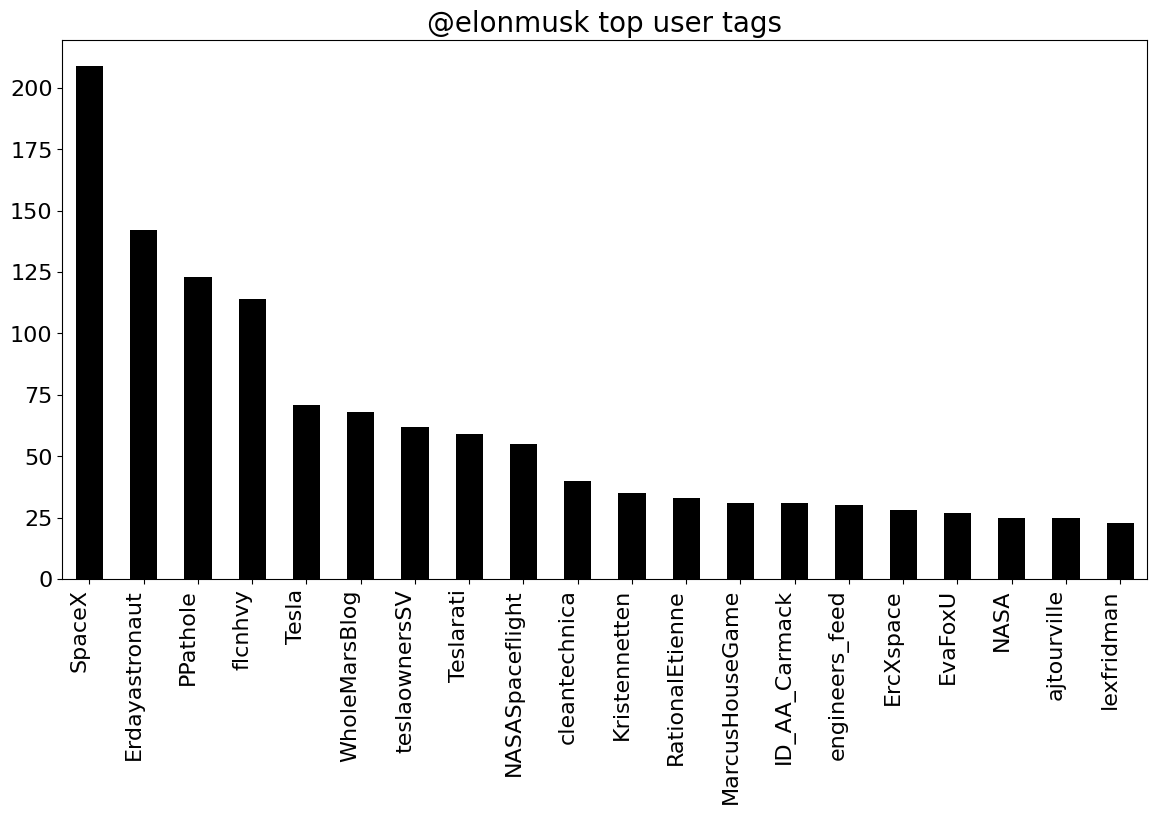

In [44]:
pd.Series(c).value_counts().head(20).plot.bar(
    figsize = (14, 7), fontsize = 16, color = 'k', 
)
plt.gca().set_title('@elonmusk top user tags', fontsize = 20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 90, ha = 'right', fontsize = 16)
pass

# Basic Text preprocessing for sentiment analysis

### Removing '@names'

In [45]:
tweets = tweets_df
tweets.head()

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


In [47]:
import re

In [48]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)

    return text

In [49]:
tweets['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], '@[\w]*')
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


### Removing links

In [52]:
cleaned_tweets = []

for index, row in tweets.iterrows():
    words_without_links = [word for word in row.Tidy_Tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['Tidy_Tweets'] = cleaned_tweets
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...


### Removing tweets with empty text

In [53]:
tweets = tweets[tweets['Tidy_Tweets'] != '']
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...


### Dropping duplicate row

In [54]:
tweets.drop_duplicates(subset = ['Tidy_Tweets'], keep = False)
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...


In [55]:
tweets = tweets.reset_index(drop = True)
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...


### Removing punctutations, numbers and special characters

In [60]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [61]:
tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: clean_text(x))
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...


### Function to remove emojis

In [62]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [64]:
tweets['Tidy_Tweets']=tweets['Tidy_Tweets'].apply(lambda x: remove_emoji(x))
tweets.head()

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...


### Removing stop wrods

In [65]:
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')
sw_list = ['im','\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets
tweets.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulations tesla china amazing execution ...


### Toeknize 'absolute_tidy_tweets'

In [67]:
tokenized_tweet = tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                              [alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulations, tesla, china, amazing, execu...
Name: absolute_tidy_tweets, dtype: object

### Converting words to Lemma

In [69]:
word_lemmatizer = WordNetLemmatizer()

nltk.download('omw-1.4')
nltk.download('wordnet')

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...


0                                              [alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulation, tesla, china, amazing, execut...
Name: absolute_tidy_tweets, dtype: object

### Joining all tokens into sentences

In [70]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets['absolute_tidy_tweets'] = tokenized_tweet
tweets.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...


# Fetch sentiments

In [71]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [72]:
sentiments_using_SIA = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,count
absolute_tidy_tweets,
pos,1737
neg,201


In [74]:
sid = SentimentIntensityAnalyzer()

df=pd.DataFrame()
df['Tweets'] = tweets.absolute_tidy_tweets
df['scores'] = tweets['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Tweets,scores
0,alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [75]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [76]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Tweets,scores,compound,sentiment
0,alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive
...,...,...,...,...
1933,true sound surreal negative propaganda still a...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative
1934,make sure read ur term amp condition clicking ...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive
1935,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1936,altho dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative


In [79]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp.style.background_gradient(cmap='rainbow')

,sentiment,Tweets
2,Positive,873
1,Neutral,836
0,Negative,229


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9472\2432481335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment',data=df, palette = 'rainbow')


<Axes: xlabel='sentiment', ylabel='count'>

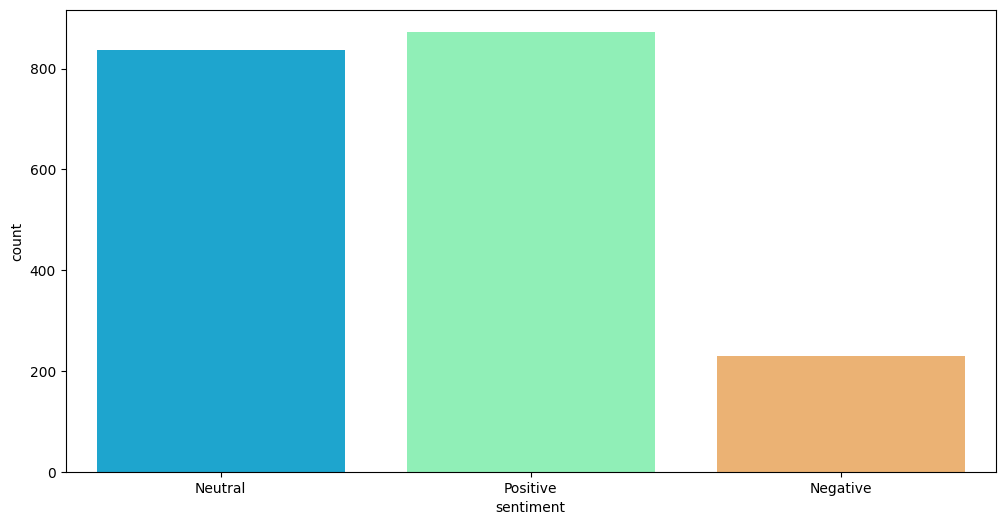

In [82]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df, palette = 'rainbow')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9472\3383353206.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['compound'])


<Axes: xlabel='compound', ylabel='Density'>

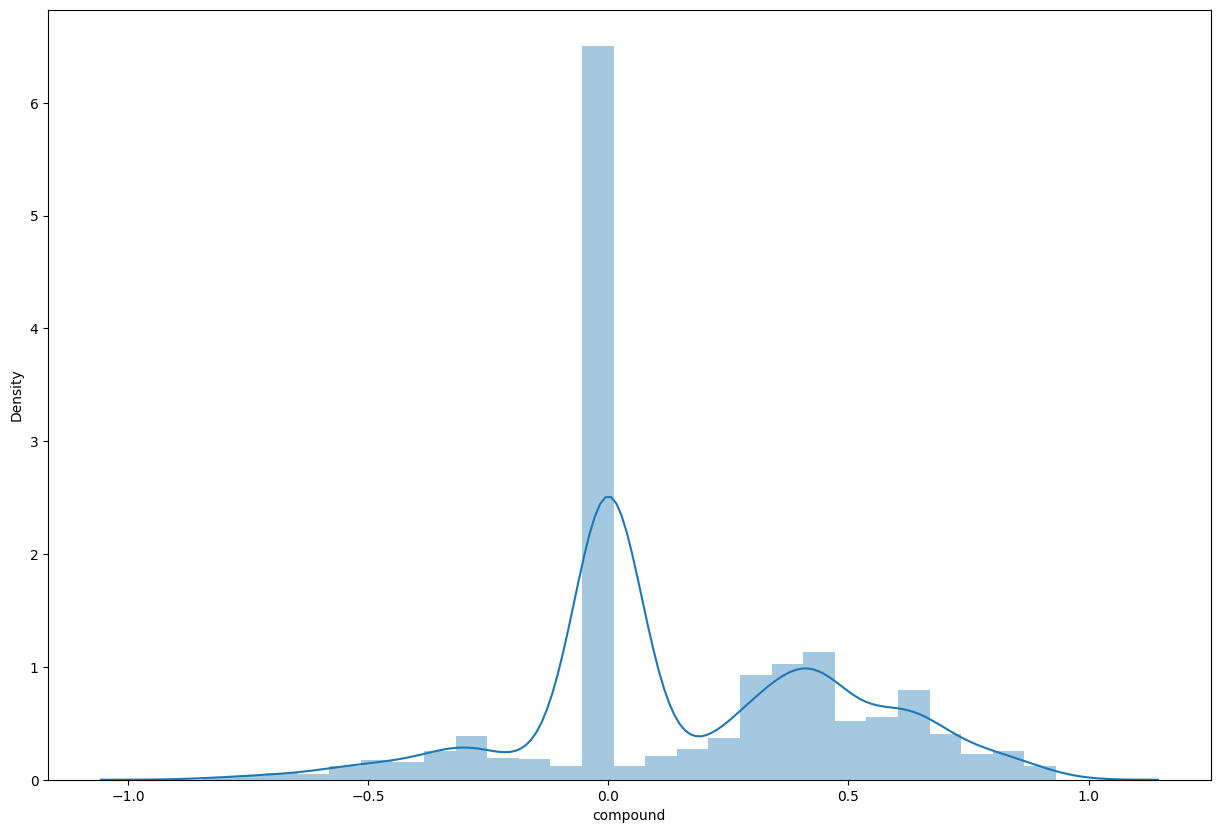

In [83]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(15,10))
sns.distplot(df['compound'])

<Axes: xlabel='None', ylabel='compound'>

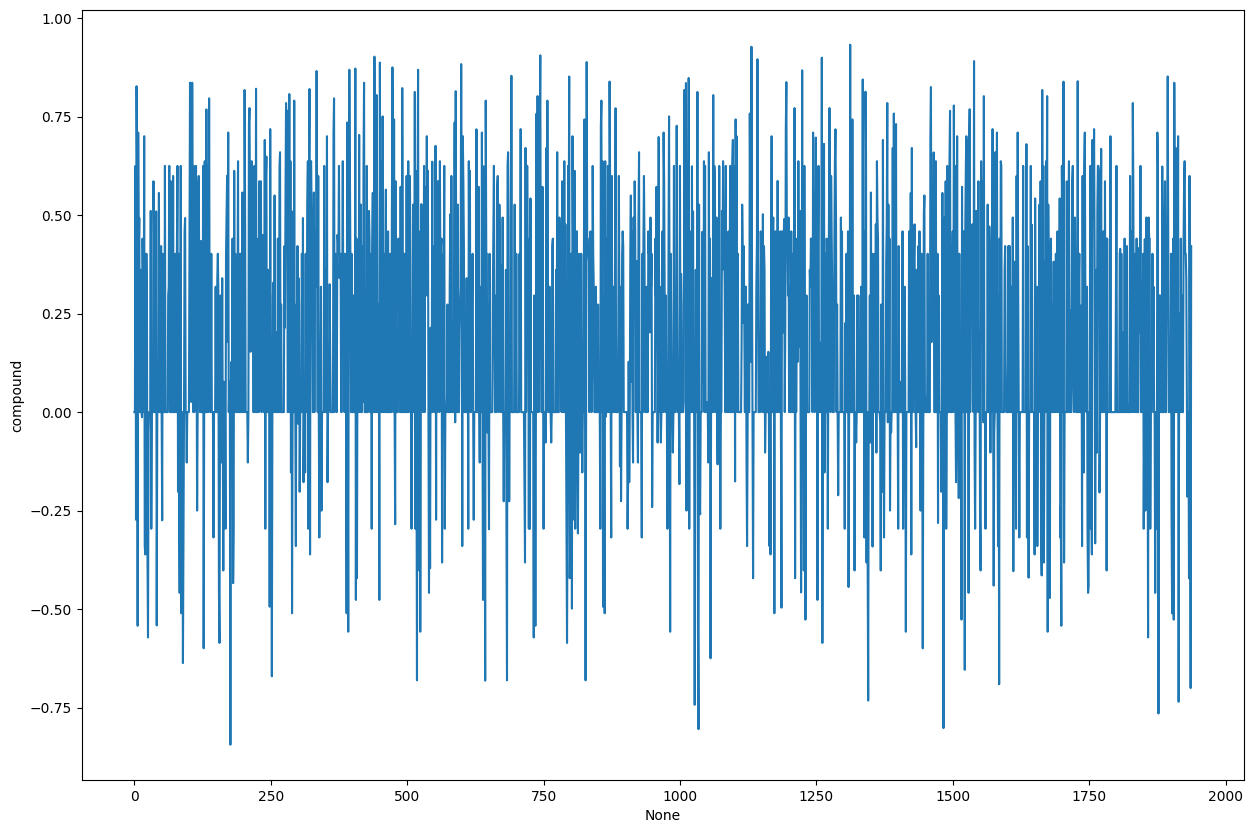

In [84]:
# Plotting the line plot for sentiment value of whole review
plt.figure(figsize=(15,10))
sns.lineplot(y='compound',x=df.index,data=df)

In [85]:
df['word_count'] = df['Tweets'].apply(lambda x: len(str(x).split(" ")))
df[['Tweets','word_count']].head()

,Tweets,word_count
0,alien,1
1,ray tracing cyberpunk hdr nextlevel tried,6
2,great interview,2
3,doge underestimated,2
4,congratulation tesla china amazing execution l...,9


<Axes: title={'center': 'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='compound'>

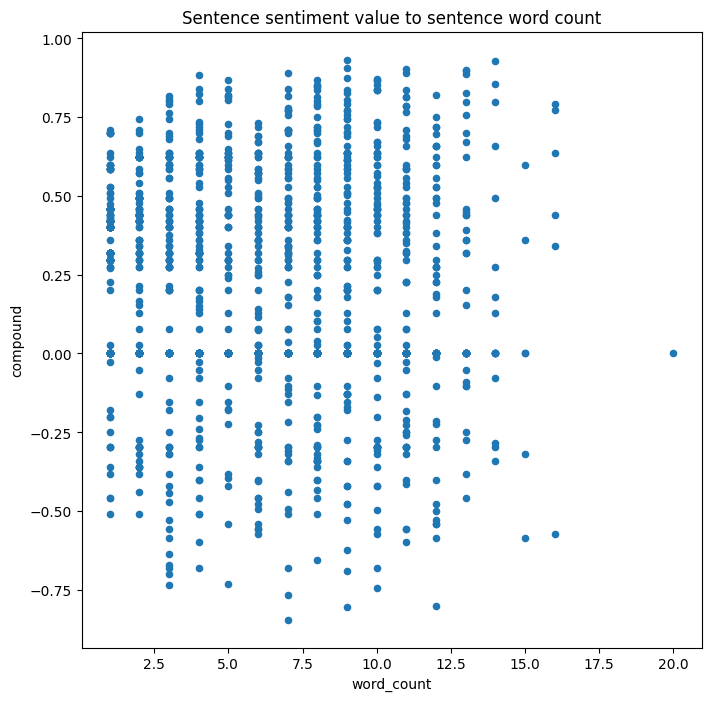

In [86]:
# Correlation analysis
df.plot.scatter(x='word_count',y='compound',figsize=(8,8),title='Sentence sentiment value to sentence word count')

# Visualization

### A. Most common words in positive tweets

In [92]:
tweets['sentiment'] = df.sentiment

In [93]:
tweets.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets,sentiment
0,@kunalb11 Im an alien,im an alien,alien,Neutral
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried,Neutral
2,@joerogan @Spotify Great interview!,great interview,great interview,Positive
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated,Negative
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...,Positive


In [94]:
tweets.describe()

,Tweets,Tidy_Tweets,absolute_tidy_tweets,sentiment
count,1938,1938,1938,1938
unique,1936,1661,1624,3
top,The most entertaining outcome is the most likely,,,Positive
freq,2,80,124,873


In [95]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

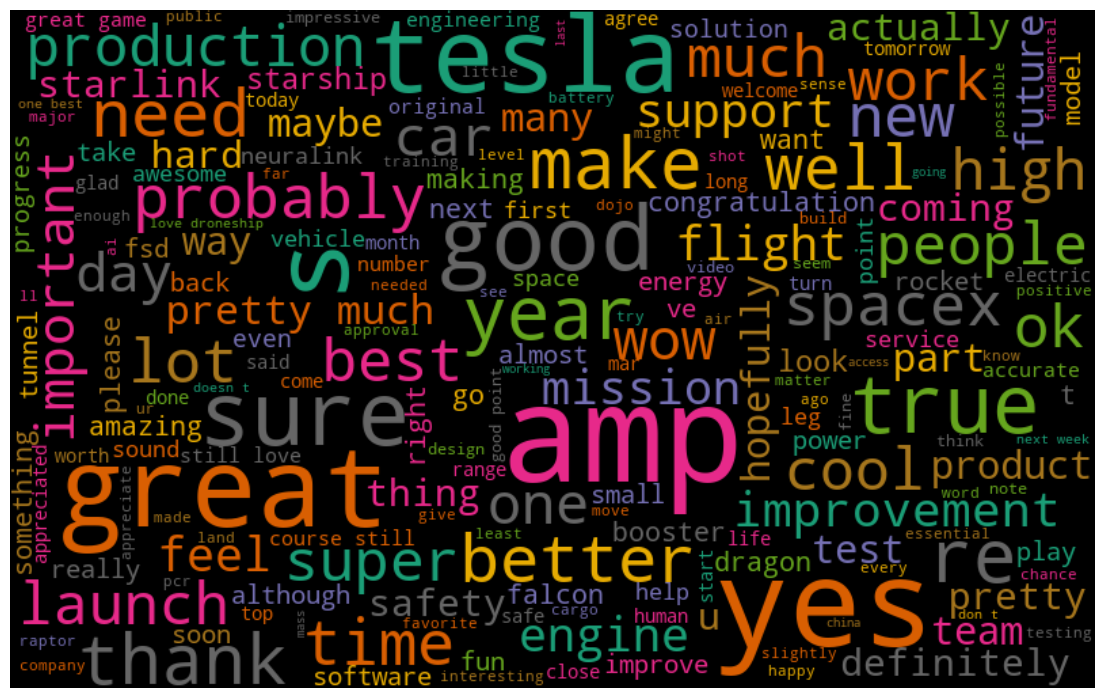

In [98]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'Positive']])
generate_wordcloud(all_words)

## B. Most common words in negative tweets

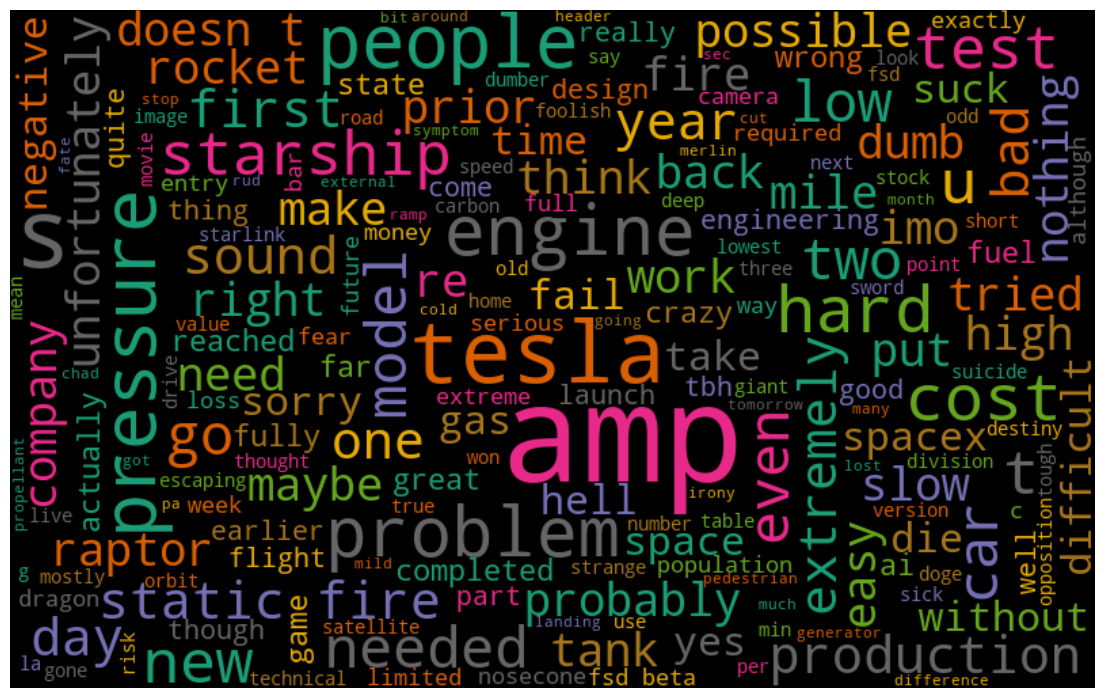

In [99]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'Negative']])
generate_wordcloud(all_words)